## Extract and align data from Onix, Harp, Sleap, and photometry
### Cohort 1 and 2 working, Cohort 0: onix_digital Clock column is 0, explore why and/or use timestamps instead 

In [ ]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import plotly.graph_objects as go
#import plotly.io as pio
#import plotly.express as px
#from plotly.subplots import make_subplots
#from scipy.stats import mode
#from scipy.integrate import cumulative_trapezoid
#from scipy.signal import correlate
#import json
#from dotmap import DotMap
import aeon.io.api as api

import gc # garbage collector for removing large variables from memory instantly 
import importlib #for force updating changed packages 

#import harp
import harp_resources.process
import harp_resources.utils
from harp_resources import process, utils # Reassign to maintain direct references for force updating 
from sleap import load_and_process as lp

%config Completer.use_jedi = False  # Fixes autocomplete issues
%config InlineBackend.figure_format = 'retina'  # Improves plot resolution

In [ ]:
# Force reload the modules
importlib.reload(harp_resources.process)
importlib.reload(harp_resources.utils)
# Reassign after reloading to ensure updated references
process = harp_resources.process
utils = harp_resources.utils

In [24]:
#initiate variables
#SLEAP FIXME WHY HERE?
score_cutoff = 0.2 # threshold to label prediction accuracy 
outlier_sd_threshold = 10 # for removing outliers from the data 
#HARP
sensor_resolution = 3100 #cpi, inferred empirical value from unit testing notebook  
ball_radius = 0.1 # meters 
event_name = "Apply halt: 2s" #event to align data to, can make into list in the future?
optical_filter_Hz = 40 #in Hz, filter cutoff for Optical tracking and encoder signals
common_resampled_rate = 1000 #in Hz
save_full_asynchronous_data = True #saves alldata before resampling
#EXP TYPE 
vestibular_mismatch = True # treats it as vestibular mismatch data, meaning events are triggered on expriement events and not photodiode 
has_sleap = True
has_heartbeat = True # true for Cohort2+ from February 18 2025 onwards 
cohort0 = False # Cohort0 is a special case, no OnixHarp in this cohort; not fully implemented 
cohort2 = True

# HELPER FLAGS, don't change  
onix_analog_clock_downsampled = False
onix_analog_framecount_upsampled = False
unit_conversions = False #
all_aligned = False

#Cohort 1 vestibular mismatch, multiple OnixDigital files 
#data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2718-2024-12-12T13-28-14') #multiple onix_digital file

#Cohort 1 vestibular mismatch, with clock accumulation issue marked on google sheet, seems fine though
#data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2719-2024-12-12T13-59-38') #multiple onix_digital file

#Cohort 1 vestibular mismatch
#data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2717-2024-12-12T13-00-21')


#Cohort 1 visual mismatch 
#data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/Visual_mismatch_day3/B6J2718-2024-12-10T12-57-02') 

#Cohort 1 visual mismatch THIS with SLEAP DATA 
data_path = Path('/Volumes/RanczLab2/20250409_Cohort3_rotation/Training_day2/B6J2783-2025-04-10T12-35-15')

#Cohort 1 visual mismatch day 4
#data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/Visual_mismatch_day4/B6J2717-2024-12-11T13-06-53')

#Frameindex issue guy 
#data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/Visual_mismatch_day3/B6J2722-2024-12-10T14-58-52')

#Cohort 0 (no OnixHarp in this Cohort)
#data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort0/Cohort0_GCaMP_example/B3M3xx-2024-08-08T10-05-26')
#cohort0 = True

#Cohort 2 (Cohort 1 animal) 
#data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort2_test/2025-02-13T12-41-57')
#has_heartbeat = True

photometry_path = data_path.parent / f"{data_path.name}_processedData" / "photometry"
sleap_data_path = data_path.parent / f"{data_path.name}_processedData"
save_path = data_path.parent / f"{data_path.name}_processedData"
session_name = "_".join(data_path.parts[-2:])

#h1_datafolder = data_path / 'HarpDataH1' #only if reading separate registers
#h2_datafolder = data_path / 'HarpDataH2' #only if reading separate registers
#h1 and h2 only needed if timestamps are readed separately and not as all harp_streams
#h1_reader = harp.create_reader('harp_resources/h1-device.yml', epoch=harp.REFERENCE_EPOCH)
#h2_reader = harp.create_reader('harp_resources/h2-device.yml', epoch=harp.REFERENCE_EPOCH)

#create loaders 
session_settings_reader = utils.SessionData("SessionSettings")
experiment_events_reader = utils.TimestampedCsvReader("ExperimentEvents", columns=["Event"])
onix_framecount_reader = utils.TimestampedCsvReader("OnixAnalogFrameCount", columns=["Index"])
#photometry_reader = utils.PhotometryReader("Processed_fluorescence")
onix_digital_reader = utils.OnixDigitalReader("OnixDigital", columns=["Value.Clock", "Value.DigitalInputs", "Seconds"])
if cohort2:
    onix_harp_reader = utils.TimestampedCsvReader("OnixHarp", columns=["Clock", "HarpTime"])
else:
    onix_harp_reader = utils.TimestampedCsvReader("OnixHarp", columns=["Clock", "HubClock", "HarpTime"])

# if not has_sleap:
#     video_reader1 = utils.VideoReader("VideoData1")
#     video_reader2 = utils.VideoReader("VideoData2")

In [15]:
print ("Loading session settings")
session_settings = utils.load_2(session_settings_reader, data_path) #Andrew's, creates ugly df, but used in further analysis code perhaps
print ("Loading experiment events")
experiment_events = utils.load_2(experiment_events_reader, data_path)

print ("Loading processed photometry")
photometry_data = pd.read_csv(str(photometry_path)+'/Processed_fluorescence.csv')
photometry_data.set_index("TimeStamp", inplace=True)
photometry_data.index.name = 'Seconds'
print ("Upsampling photometry data to common_resample_rate")
photometry_data = process.upsample_photometry(photometry_data, common_resampled_rate)
print ("Loading processed photometry info")
photometry_info = pd.read_csv(str(photometry_path) + '/Info.csv', header=None, names=["Parameter", "Value"])
print ("Loading processed photometry events")
photometry_events=pd.read_csv(str(photometry_path)+'/Events.csv')
photometry_events["TimeStamp"] = photometry_events["TimeStamp"] /1000 # convert to seconds from ms
photometry_events.set_index("TimeStamp", inplace=True)
photometry_events.index.name = 'Seconds'

# read SLEAP data (but if not presend, don't even load video_data instead)- ANR hack 
if not cohort2 and not has_sleap:
    pass # so it works with everything commented out 
    #print ("Loading video data 1")
    #video_data1 = utils.load_2(video_reader1, data_path)
    #print ("Loading video data 2")
    #video_data2 = utils.load_2(video_reader2, data_path)
else: 
    desired_columns = ["frame_idx", "Seconds",
    "left.x", "left.y", "center.x", "center.y", "right.x", "right.y",
    "Ellipse.Diameter", "Ellipse.Angle", "Ellipse.Center.X", "Ellipse.Center.Y"]
    
    if os.path.isdir(os.path.join(str(sleap_data_path), 'Video_Sleap_Data1')): 
        print(f'Loading Video_Sleap_Data1')
        video_data1 = pd.read_csv(str(sleap_data_path)+'/Video_Sleap_Data1/Video_Sleap_Data1_1904-01-01T00-00-00.csv') 
        video_data1.set_index(pd.to_datetime(video_data1['Seconds'].apply(api.aeon)), inplace=True)
        video_data1 = video_data1[desired_columns]
        VideoData1_Has_Sleap = True #FIXME remove when SLEAP processing has been integrated 

    elif os.path.isdir(os.path.join(str(sleap_data_path), 'Video_Sleap_Data2')):
        print("Loading Video_Sleap_Data1.csv")
        video_data2 = pd.read_csv(str(sleap_data_path)+'/Video_Sleap_Data2/Video_Sleap_Data2_1904-01-01T00-00-00.csv')
        video_data2.set_index(pd.to_datetime(video_data2['Seconds'].apply(api.aeon)), inplace=True)
        video_data2 = video_data2[desired_columns]
        videodata2_Has_Sleap = True #FIXME remove when SLEAP processing has been integrated 
        
    else:
        print ("⚠️ Warning.  No processed Video_Sleap_Data*.csv found in _processedData/Video_Sleap_Data*. Process data first if you want to use it")
        #USE THIS after analysis in SANDBOX_1_Loading_SLEAP has been made into functions an integrated here 
        #FIXME load multiple csv files 
        # VideoData1, VideoData2, VideoData1_Has_Sleap, VideoData2_Has_Sleap = lp.load_videography_data(data_path)
        # if VideoData1_Has_Sleap:
        #     VideoData1 = VideoData1.drop(columns=['track']) # drop the track column as it is empty
        # if VideoData2_Has_Sleap:
        #     VideoData2 = VideoData2.drop(columns=['track']) # drop the track column as it is empty
    
    
# read Onix data 
print ("Loading OnixDigital")
onix_digital = utils.load_2(onix_digital_reader, data_path)

if cohort0:
    print ("Loading OnixAnalogFrameClock")
    onix_analog_framecount = utils.load_2(onix_framecount_reader, data_path)
    
print ("Loading OnixAnalogClock")
onix_analog_clock = utils.read_OnixAnalogClock(data_path)

print ("Loading OnixAnalogData and converting to boolean photodiode array")
#method adaptive or threshold (which is hard threshold at 120), 
#refractory in seconds (aasuming 100kHz sampling rate) to avoid multiple detections in reporting
#first 2 minutes removed from reporting 
photodiode = utils.read_OnixAnalogData(data_path, channels = [0], binarise=True, method='adaptive', refractory = 0.5, flip=True, verbose=True) 

#read HARP data
print ("Loading H1 and H2 streams, AnalogInput removed")
harp_streams = utils.load_registers(data_path, dataframe = True, has_heartbeat = has_heartbeat, verbose = False) #loads as df, or if False, as dict
harp_streams.drop(columns=["AnalogInput(39)"], inplace=True)  # Removes AnalogInput permanently, as not currently used
harp_streams = harp_streams.dropna(how="all") # remove rows with all NaNs
# Convert specific columns in harp_streams to boolean type
columns_to_convert = ["StartCam0(38)", "StartCam1(38)", "StopCam0(38)", "StopCam1(38)"]
for col in columns_to_convert:
    harp_streams[col] = harp_streams[col].astype(bool)

#read syncronising signal between HARP and ONIX
if not cohort0:
    print ("Loading OnixHarp")
    onix_harp = utils.load_2(onix_harp_reader, data_path)
    onix_harp = utils.detect_and_remove_outliers(
    df=onix_harp,
    x_column="HarpTime",
    y_column="Clock",
    verbose=False  # True prints all outliers
    )
    onix_harp["HarpTime"] = onix_harp["HarpTime"] + 1 # known issue with current version of ONIX, harp timestamps lag 1 second
    print ("ℹ️ Reminder: HarpTime was increased by 1s to account for known issue with ONIX which may be solved by open ephys update in the future")
 
print ("✅ Done Loading")

Loading session settings
Loading experiment events
Loading processed photometry
Upsampling photometry data to common_resample_rate
Loading processed photometry info
Loading processed photometry events
⚠️ Warning.  No processed Video_Sleap_Data*.csv found in _processedData/Video_Sleap_Data*. Process data first if you want to use it
Loading OnixDigital
Loading OnixAnalogClock
Loading OnixAnalogData and converting to boolean photodiode array
Adaptive threshold: 96.0
❗Warning: No falling edges detected. Check threshold value and signal.
Loading H1 and H2 streams, AnalogInput removed
Loading OnixHarp
ℹ️ Reminder: HarpTime was increased by 1s to account for known issue with ONIX which may be solved by open ephys update in the future
✅ Done Loading


## Convert platform position and flow sensor streams to real world units

In [16]:
# Get encoder values for homing and next event positions as absolute real life 0 position 
homing_position, next_event_position = process.get_encoder_home_position(experiment_events, harp_streams)
print("⚠️ Warning: home position is determined by the time of the experiment event after 'Homing platform'. It works for e.g. 'Waiting for run threshold' which starts immediately after homing, but may not work for other session types.")

# Perform unit conversions if not already done
if not unit_conversions:
    #get raw cumulative counts as position in raw data counts for plotting only 
    harp_streams["CumulativeCounts_0X"] = harp_streams["OpticalTrackingRead0X(46)"].copy().cumsum()
    harp_streams["CumulativeCounts_0Y"] = harp_streams["OpticalTrackingRead0Y(46)"].copy().cumsum()
    # run conversions
    harp_streams["Position_0X"] = process.running_unit_conversion(harp_streams["OpticalTrackingRead0X(46)"].copy().cumsum().ffill().bfill().to_numpy(), sensor_resolution)
    harp_streams["Position_0Y"] = process.turning_unit_conversion(harp_streams["OpticalTrackingRead0Y(46)"].copy().cumsum().ffill().bfill().to_numpy(), sensor_resolution, ball_radius)

    harp_streams["Encoder(38)"] = harp_streams["Encoder(38)"].ffill().bfill() #fill before unit conversion
    harp_streams["Encoder(38)"] = process.encoder_unit_conversion(
        harp_streams["Encoder(38)"], next_event_position)
    
    #convert CamXEvents to bool 
    harp_streams["Cam0Event(32)"] = harp_streams["Cam0Event(32)"].fillna(0).astype(bool)
    harp_streams["Cam1Event(33)"] = harp_streams["Cam1Event(33)"].fillna(0).astype(bool)
    unit_conversions = True
    print("✅ Unit conversions to real-life values done")
else:
    print("❗ Flow sensor and encoder values already converted to real-world units, skipping")

⚠️ Warning: home position is determined by the time of the experiment event after 'Homing platform'. It works for e.g. 'Waiting for run threshold' which starts immediately after homing, but may not work for other session types.
✅ Unit conversions to real-life values done


### Downsamples photodiode and analog_clock to common rate (10 kHz) and aligned photodiode_df to harptime - for Cohort 0 also upsamples framecount, not used for Cohort1+

In [17]:
# gets analog data sample rate and downsamples to common_resampled_rate * 10
if not onix_analog_clock_downsampled:
    onix_analog_clock_s = (onix_analog_clock * 4) * 1e-9  # convert to seconds with 250MHz DeviceClock, set in hardware
    oac_diff = np.diff(onix_analog_clock_s)
    onix_analog_rate = round(1 / (np.median(oac_diff)))  # to get the sampling rate (in Hz) with 250MHz DeviceClock, set in hardware
    downsample_factor = int(onix_analog_rate / (common_resampled_rate*10))
    print(f"onix_analog_clock rate: {onix_analog_rate}, downsample factor: {downsample_factor}")
    
    onix_analog_clock = process.downsample_numpy(onix_analog_clock, downsample_factor, method="mean")
    photodiode = process.downsample_numpy(photodiode, downsample_factor, method="mean")
    photodiode_df = pd.DataFrame({"Photodiode": photodiode.astype(bool)}, index=pd.Index(onix_analog_clock, name="onix_analog_clock"))
     
    del onix_analog_clock, oac_diff, photodiode, onix_analog_clock_s
    gc.collect()
    onix_analog_clock_downsampled = True
    print("✅ Done downsampling analog_clock and photodiode")
else:
    print("❗ onix_analog_clock & photodiode already downsampled, skipping")

# framecount upsampling, only used in Cohort 0 synchronization
if cohort0:
    if not onix_analog_framecount_upsampled:
        upsample_factor = int(100 / downsample_factor)  # framecount counts every 100 analog datapoints
        df = onix_analog_framecount
        new_index = np.linspace(0, len(df) - 1, len(df) * upsample_factor)
        onix_analog_framecount = pd.DataFrame(index=new_index)
        for col in df.columns:
            onix_analog_framecount[col] = np.interp(new_index, np.arange(len(df)), df[col])
        del new_index
        gc.collect()
        # Check onix_analog shapes for consistency
        data_len = photodiode.shape[0]
        clock_len = onix_analog_clock.shape[0]
        framecount_len = len(onix_analog_framecount)

        if data_len != framecount_len or clock_len != framecount_len:
            offset = framecount_len - clock_len
            onix_analog_framecount = onix_analog_framecount.iloc[offset:]
            print(f"⚠️Warning: analog_data and _framecount mismatch, framecount truncated by {offset * 10}! Should be OK, but see https://github.com/neurogears/vestibular-vr/issues/81 for more information.")
        else:
            print("onix_analog shapes are consistent!")
        onix_analog_framecount_upsampled = True
        print("✅ Done upsampling analog_frameclock")
    else:
        print("❗ onix_analog_framecount already upsampled, skipping")


onix_analog_clock rate: 100000, downsample factor: 10
✅ Done downsampling analog_clock and photodiode


for onix to harp o_m: 4.00735493712311e-09, o_b: 87516.0925080945
R-squared value for harp to onix: 0.9999999999999198
for photometry to harp m: 249545573.47651035, b: 7208464637.637138
R-squared value for photometry to onix: 0.9999999998041593
393 events found
Plotting the first 15 sync events


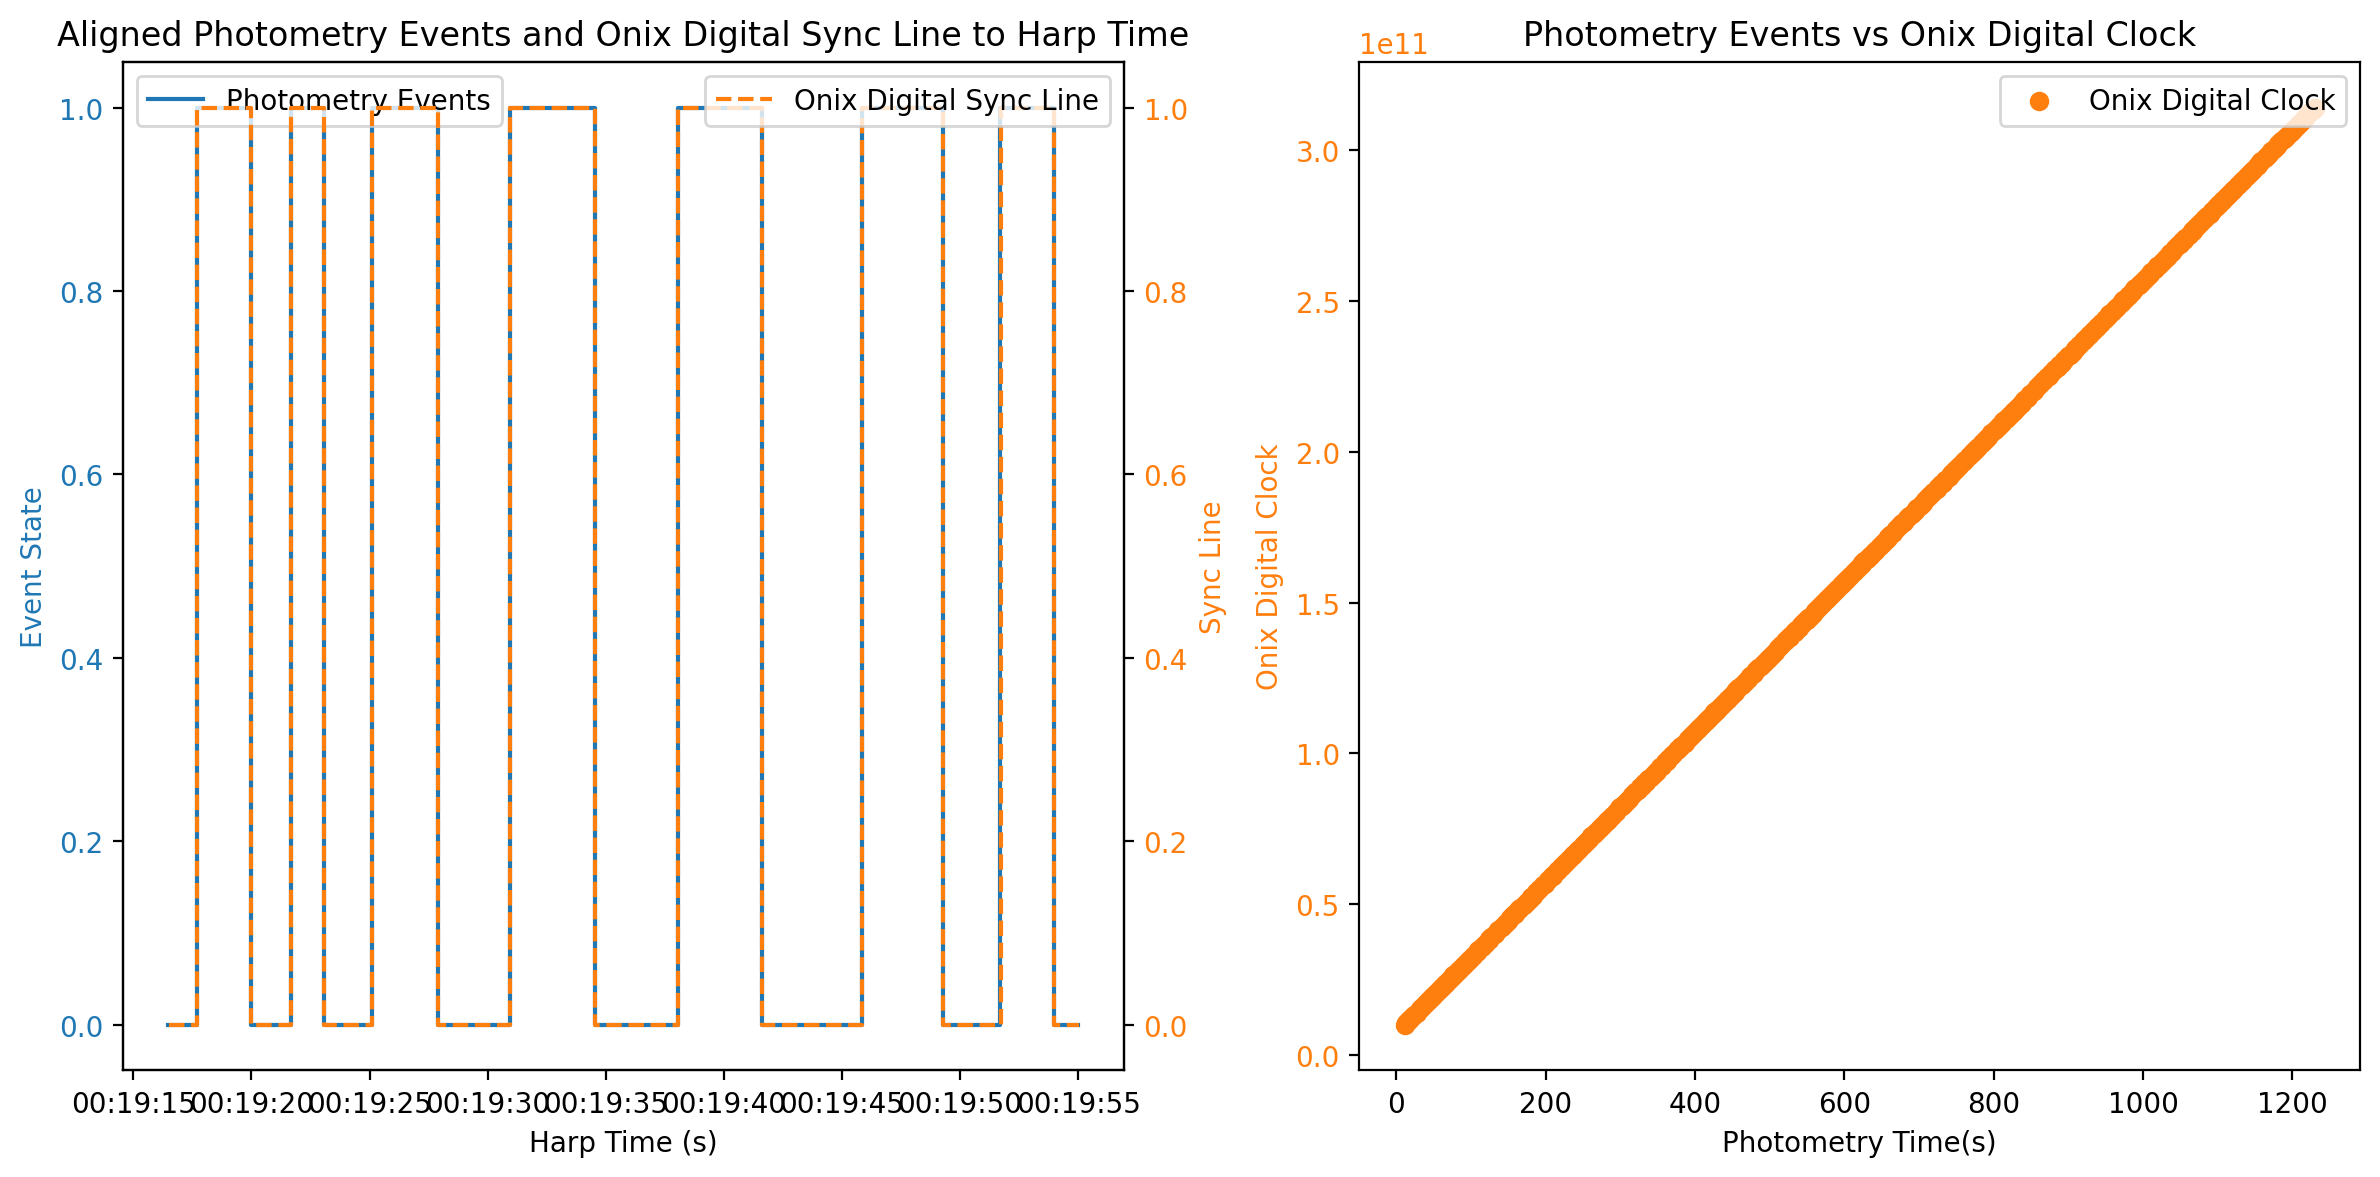

✅ Done aligning photometry and photodiode
❗ Reminder: Photodiode is funky at startup and is set to True before the first 'Check halt probability' event, may not work with all experiment types


In [18]:
if not all_aligned:
    ( 
        conversions, 
        photometry_aligned,
        photodiode_aligned
    ) = process.photometry_harp_onix_synchronisation(
        onix_digital=onix_digital,
        onix_harp=onix_harp,
        photometry_events=photometry_events,
        photometry_data = photometry_data,
        photodiode_df = photodiode_df,
        verbose=True
    )
    del photodiode_df
    gc.collect()
    all_aligned = True   
    print("✅ Done aligning photometry and photodiode")
else:
    print("❗ Photometry and photodiode already aligned, skipping")

#Set all values of photodiode_aligned before the first "Check halt probability" to True
if "Check halt probability" in experiment_events["Event"].values:
    next_event_after_homing = experiment_events[experiment_events["Event"] == "Check halt probability"].index[0]
else:
    next_event_after_homing = experiment_events[experiment_events["Event"] == "Wait for run threshold..."].index[0]

photodiode_aligned.loc[photodiode_aligned.index < next_event_after_homing, "Photodiode"] = True
print ("❗ Reminder: Photodiode is funky at startup and is set to True before the first 'Check halt probability' event, may not work with all experiment types")


In [19]:
#finding global first and last timestamps
streams_dict = {
    'session_settings': {'session_settings': session_settings},
    'experiment_events': {'experiment_events': experiment_events},
    'harp_streams': {'harp_streams': harp_streams},
    'onix_harp': {'onix_harp': onix_harp},
    'onix_digital': {'onix_digital': onix_digital},
    'harp_streams': {'harp_streams': harp_streams},
    'photodiode_aligned': {'photodiode_aligned': photodiode_aligned},
    'photometry_aligned': {'photometry_aligned': photometry_aligned}
}
if cohort0:
    streams_dict['onix_analog_framecount'] = {'onix_analog_framecount': onix_analog_framecount}

global_first_timestamp, global_last_timestamp, streams_dict = process.get_global_minmax_timestamps(streams_dict, print_all=False, verbose=True)

# Extract all DataFrames dynamically
for source_name, registers in streams_dict.items():
    for register_name, df in registers.items():
        globals()[register_name] = df  # Create variables dynamically

del registers, onix_digital, onix_harp, photometry_events, photometry_data
gc.collect()

# padding these dataframes to global first and last timestamp and bringing under new alldata dataframe
dataframes = []
if 'video_data1' in globals():
    dataframes.append(video_data1)
if 'video_data2' in globals():
    dataframes.append(video_data2)
dataframes.extend([harp_streams, photometry_aligned, photodiode_aligned])

padded_dataframes = [process.pad_dataframe_with_global_timestamps(df, global_first_timestamp, global_last_timestamp) for df in dataframes]

if 'video_data1' in globals() and 'video_data2' in globals():
    video_data1, video_data2, harp_streams, photometry_aligned, photodiode_aligned = padded_dataframes
elif 'video_data1' in globals():
    video_data1, harp_streams, photometry_aligned, photodiode_aligned = padded_dataframes
elif 'video_data2' in globals():
    video_data2, harp_streams, photometry_aligned, photodiode_aligned = padded_dataframes
else:
    harp_streams, photometry_aligned, photodiode_aligned = padded_dataframes

del padded_dataframes, streams_dict, dataframes
gc.collect()
None

Global first timestamp: 1904-01-02 00:19:04.999387
Global first timestamp from: photometry_aligned/photometry_aligned
Global last timestamp: 1904-01-02 00:39:52.023441
Global last timestamp from: photometry_aligned/photometry_aligned
Global length: 0 days 00:20:47.024054


/Users/nora/Documents/GitHub/vestibular_vr_pipeline/harp_resources/process.py:434: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



### combine alldata to single df and save 
use this to load it when necessary:
df = pd.read_parquet("path/to/my_data.parquet", engine="pyarrow")


In [20]:
# Combine all dataframes into a single dataframe

# Rename columns in harp_streams by removing "OpticalTrackingRead" and removing register numbers
if 'video_data1' in globals():
    video_data1 = video_data1.rename(columns=lambda x: f"{x}_eye1" if not x.endswith("_eye1") else x)
if 'video_data2' in globals():
    video_data2 = video_data2.rename(columns=lambda x: f"{x}_eye2" if not x.endswith("_eye2") else x)
harp_streams.columns = harp_streams.columns.str.replace("OpticalTrackingRead", "Displacement_", regex=False)
harp_streams.columns = harp_streams.columns.str.replace(r"\(.*\)", "", regex=True)
harp_streams.columns = harp_streams.columns.str.replace("Position_Displacement_", "Position_", regex=False)
harp_streams.columns = harp_streams.columns.str.replace("Displacement_0Brightness", "Brightness_0", regex=False)
harp_streams.columns = harp_streams.columns.str.replace("Displacement_1Brightness", "Brightness_1", regex=False)

# Concatenate the dataframes
if 'video_data1' in globals():
    alldata = pd.concat([video_data1, harp_streams, photometry_aligned, photodiode_aligned], axis=1)
if 'video_data2' in globals():
    alldata = pd.concat([video_data1, harp_streams, photometry_aligned, photodiode_aligned], axis=1)
if 'video_data1' in globals() and 'video_data2' in globals():
    alldata = pd.concat([video_data1, video_data2, harp_streams, photometry_aligned, photodiode_aligned], axis=1)
if 'video_data1' not in globals() and 'video_data2' not in globals():
    alldata = pd.concat([harp_streams, photometry_aligned, photodiode_aligned], axis=1)  

# Define photodiode_int DataFrame and add to alldata
photodiode_int = pd.DataFrame(dtype=int)  # Ensure DataFrame defaults to int
photodiode_int["Photodiode_int"] = photodiode_aligned["Photodiode"].astype("int8").copy()
photodiode_int = photodiode_int.reindex(alldata.index, method='ffill') ## Reindex photodiode_int to match alldata's index, filling missing values with the preceding value
alldata = pd.concat([alldata, photodiode_int], axis=1)
alldata["Photodiode_int"] = alldata["Photodiode_int"].astype("int8") # insure it is int8

# Ensure boolean columns retain their dtype
bool_columns = ["Cam0Event", "Cam1Event", "StartCam0", "StartCam1", "StopCam0", "StopCam1", "Photodiode"]
for col in bool_columns:
    if col in alldata.columns:
        if col == "Photodiode":
            pd.set_option('future.no_silent_downcasting', True)  # Enable future behavior
            alldata[col] = alldata[col].infer_objects(copy=False)  # Convert object columns properly
            alldata[col] = alldata[col].ffill().astype(bool)
        else:
            alldata[col] = alldata[col].fillna(0).astype(bool)

print("✅ Concatenated all data streams into alldata")

if save_full_asynchronous_data:
    filename = "alldata_asynchronous.parquet"
    full_path = save_path / filename
    alldata.to_parquet(full_path, engine="pyarrow", compression="snappy")   
    print("✅ Saved full asynchronous data to alldata_asynchronous.parquet")

# Clean up and delete the column OpticalTrackingRead0X(46) and camera start/stop and H2 ImmediatePulses
del photometry_aligned, harp_streams, photodiode_aligned, photodiode_int
if 'video_data1' in globals():
    del video_data1
if 'video_data2' in globals():
    del video_data2
gc.collect()

columns_to_delete = [
    "Displacement_0X",
    "Displacement_0Y",
    "Displacement_1X",
    "Displacement_1Y",
    "Brightness_0",
    "Brightness_1",
    "StartCam0", 
    "StartCam1", 
    "StopCam0",
    "StopCam1", 
    "ImmediatePulses"
]
alldata.drop(columns=columns_to_delete, inplace=True)

#---------------------------------------------------
# Separate data streams to be resampled from the ones to keep for now with original datetime indices 
#---------------------------------------------------

columns_to_select = [
    'Cam0Event', 'Cam1Event', 'Photodiode',
    #'HardwareCounter_1', 'HardwareTimestamp_1', 
    #'HardwareCounter_2', 'HardwareTimestamp_2',
]

camera_photodiode_data = alldata[columns_to_select].copy()
camera_photodiode_data.index = alldata.index

#Remove the selected columns from alldata
for col in columns_to_select:
    alldata.pop(col)

photometry_tracking_encoder_data = alldata
del alldata
gc.collect()
print("✅ Done separating data streams to float and bool/Int64")

✅ Concatenated all data streams into alldata
✅ Saved full asynchronous data to alldata_asynchronous.parquet
✅ Done separating data streams to float and bool/Int64


In [21]:
# Define a dictionary containing the columns to be interpolated

if 'video_data1' in globals():
    columns_to_interpolate = {
        'Ellipse.Center.X_eye1': 'linear',
        'Ellipse.Center.Y_eye1': 'linear',
        'Ellipse.Diameter_eye1': 'linear'
    }

if 'video_data2' in globals():
    columns_to_interpolate = {
        'Ellipse.Center.X_eye2': 'linear',
        'Ellipse.Center.Y_eye2': 'linear',
        'Ellipse.Diameter_eye2': 'linear'
    }

if 'video_data1' in globals() and 'video_data2' in globals():
    columns_to_interpolate = {
        'Ellipse.Center.X_eye1': 'linear',
        'Ellipse.Center.Y_eye1': 'linear',
        'Ellipse.Diameter_eye1': 'linear',
        'Ellipse.Center.X_eye2': 'linear',
        'Ellipse.Center.Y_eye2': 'linear',
        'Ellipse.Diameter_eye2': 'linear'
    }

# Iterate over the dictionary and apply interpolation
if 'video_data1' in globals() or 'video_data2' in globals():
    for col, method in columns_to_interpolate.items():
        photometry_tracking_encoder_data[col] = (
            photometry_tracking_encoder_data[col]
            .interpolate(method=method)
            .ffill()
            .bfill()
        )


### Downsample to common_sample_rate (1 kHz), takes a long time, then calculate veloity and acceleartion, photodiode events  
### Save all downsampled data and  plot all data and save figure

In [22]:
photometry_tracking_encoder_data = process.resample_dataframe(photometry_tracking_encoder_data, common_resampled_rate, optical_filter_Hz)
print("✅ Resampled data to common rate", common_resampled_rate, "Hz")

✅ Resampled data to common rate 1000 Hz


In [23]:
# Calculate motor velocity and acceleration from encoder position data
photometry_tracking_encoder_data["Encoder_Unwrapped"] = np.unwrap(np.deg2rad(photometry_tracking_encoder_data["Encoder"])) * (180 / np.pi)

# Calculate motor velocity and acceleration from unwrapped encoder position data
photometry_tracking_encoder_data["Motor_Velocity"] = np.gradient(photometry_tracking_encoder_data["Encoder_Unwrapped"], edge_order=2) * common_resampled_rate
photometry_tracking_encoder_data["Motor_Velocity"] = process.low_pass_filter(photometry_tracking_encoder_data["Motor_Velocity"].dropna(), optical_filter_Hz / 40, common_resampled_rate)
photometry_tracking_encoder_data["Motor_Acceleration"] = np.gradient(photometry_tracking_encoder_data["Motor_Velocity"], edge_order=2) * common_resampled_rate
photometry_tracking_encoder_data["Motor_Acceleration"] = process.low_pass_filter(photometry_tracking_encoder_data["Motor_Acceleration"].dropna(), optical_filter_Hz / 80, common_resampled_rate)

# Calculate animal running and turning velocity and acceleration from X and Y position 
position_columns = [col for col in photometry_tracking_encoder_data.columns if col.startswith("Position_")]
for col in position_columns:
    # Calculate velocity as the first derivative of position using central difference
    velocity_col = col.replace("Position_", "Velocity_")
    photometry_tracking_encoder_data[velocity_col] = np.gradient(photometry_tracking_encoder_data[col], edge_order=2) * common_resampled_rate
    
    # Apply low-pass filter to the velocity data
    photometry_tracking_encoder_data[velocity_col] = process.low_pass_filter(photometry_tracking_encoder_data[velocity_col].dropna(), optical_filter_Hz / 40, common_resampled_rate)
    
    # Calculate acceleration as the first derivative of filtered velocity using central difference
    acceleration_col = col.replace("Position_", "Acceleration_")
    photometry_tracking_encoder_data[acceleration_col] = np.gradient(photometry_tracking_encoder_data[velocity_col], edge_order=2) * common_resampled_rate
    
    # Apply low-pass filter to the acceleration data
    photometry_tracking_encoder_data[acceleration_col] = process.low_pass_filter(photometry_tracking_encoder_data[acceleration_col].dropna(), optical_filter_Hz / 80, common_resampled_rate)

print("✅ Calculated velocity and acceleration from position data")

# Store downsampled data in separate directory 
output_dir = "downsampled_data"
full_path = save_path / output_dir
os.makedirs(full_path, exist_ok=True)

# Save each DataFrame separately
dfs = {"photometry_tracking_encoder_data": photometry_tracking_encoder_data, "camera_photodiode_data": camera_photodiode_data, "experiment_events": experiment_events, "photometry_info": photometry_info}
for name, df in dfs.items():
    df.to_parquet(full_path / f"{name}.parquet", engine='pyarrow', compression='snappy')

del dfs
gc.collect()

# Convert metadata column properly
session_settings["metadata"] = session_settings["metadata"].apply(process.safe_to_json)
# Save DataFrame to Parquet
parquet_path = full_path / "session_settings.parquet"
session_settings.to_parquet(parquet_path, engine="pyarrow", compression="snappy")

print(f"✅ Saved all processed data to {full_path}")

df_to_analyze = photometry_tracking_encoder_data["Photodiode_int"] #using downsampled values in common time grid 
if vestibular_mismatch: #determine halt times based on experiment events 
    photodiode_halts = experiment_events[experiment_events["Event"] == event_name].index.tolist()
    nearest_indices = photometry_tracking_encoder_data.index.get_indexer(photodiode_halts, method='nearest')
    photodiode_halts = photometry_tracking_encoder_data.index[nearest_indices] # as experiment events timestamps are not in the same time grid as downsampled data
    print ("INFO: vestibular mismatch data without MM signal in the photodiode, using experiment events for MM times")
else: #determine exact halt times based on photodiode signal
    photodiode_halts, photodiode_delay_min, photodiode_delay_avg, photodiode_delay_max = process.analyze_photodiode(df_to_analyze, experiment_events, event_name, plot = True)


#df_to_analyze = camera_photodiode_data["Photodiode"] #use async raw values if needed for troubleshooting, but the nearest indices needs to be found , see couple of lines below
# nearest_indices = photometry_tracking_encoder_data.index.get_indexer(photodiode_halts, method='nearest')
# photodiode_halts = photometry_tracking_encoder_data.index[nearest_indices]

del df_to_analyze
gc.collect()

process.plot_figure_1(photometry_tracking_encoder_data, session_name, save_path, common_resampled_rate, photodiode_halts, save_figure = True, show_figure = True, downsample_factor=50)
print("✅ Got photodiode events, saved Figure 1")


✅ Calculated velocity and acceleration from position data
✅ Saved all processed data to /Volumes/RanczLab2/20250409_Cohort3_rotation/Training_day2/B6J2783-2025-04-10T12-35-15_processedData/downsampled_data


IndexError: index 0 is out of bounds for axis 0 with size 0